# Continuous Wavelet Transform

> Simple wrapper around `pywt.cwt` to perform continuous wavelet transform.

In [ ]:
#| default_exp wavelets

In [ ]:
#| export
import pycwt
from pycwt import cwt
import fastcore.all as fc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
#| hide
from sklearn.pipeline import Pipeline
from uhina.preprocessing import SNV, TakeDerivative

import warnings
warnings.filterwarnings('ignore')

/Users/franckalbinet/mambaforge/envs/uhina/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| exports
class CWT: 
    def __init__(self, data, dt=2, mother=pycwt.Morlet(6)):
        fc.store_attr()
        self.normalize()
        self.init_params()
        
    def init_params(self):
        self.N = self.data.size
        self.s0 = 2 * self.dt  # Starting scale, in this case 2 * 0.25 years = 6 months  
        self.dj = 1 / 12  # Twelve sub-octaves per octaves
        self.J = 7 / self.dj  # Seven powers of two with dj sub-octaves
            
    def normalize(self):
        self.std = self.data.std()  # Standard deviation
        self.var = self.std ** 2  # Variance
        self.data /= self.std  # Normalized dataset
    
    def get_wavelet(self):
        cwt_results = cwt(self.data, self.dt, self.dj, self.s0, self.J, self.mother)
        (self.wave, self.scales, self.freqs, self.coi, self.fft, self.fftfreqs) = cwt_results
    
    def get_powers(self):    
        self.power = (np.abs(self.wave)) ** 2
    
    def get_period(self): 
        self.period = 1 / self.freqs
    
    def __call__(self):
        self.get_wavelet()
        self.get_powers()
        self.get_period()
        return self

In [ ]:
#| exports
def plot_cwt(cwt, wavenumbers, levels=None, dt=2,
             figprops=dict(figsize=(6, 2), dpi=144), tight=True, 
             fontsize=8, title='', save_path=None, show_plot=True):
    fig, ax = plt.subplots(**figprops)
    if levels is None:
        # levels = [np.percentile(cwt.power, p) for p in [10, 20, 30, 40, 50, 75, 90, 95, 99, 99.5]]
        percentiles = [i for i in range(60, 100)]
        # levels = [np.percentile(cwt.power, p) for p in [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99, 99.5]]
        levels = [np.percentile(cwt.power, p) for p in percentiles]
        
        
        
        # levels = [np.percentile(cwt.power, p) for p in [60, 75, 90, 95, 99, 99.5]]
        
    log2_levels = np.log2(levels)
    contourf = ax.contourf(wavenumbers, np.log2(cwt.period), np.log2(cwt.power), log2_levels,
                           extend='both', cmap=plt.cm.viridis)
                        # extend='both', cmap=plt.cm.YlGnBu_r)
    extent = [wavenumbers.min(), wavenumbers.max(), 0, max(cwt.period)]

    ax.fill(np.concatenate([wavenumbers, wavenumbers[-1:] + dt, wavenumbers[-1:] + dt,
                           wavenumbers[:1] - dt, wavenumbers[:1] - dt]),
            np.concatenate([np.log2(cwt.coi), [1e-9], np.log2(cwt.period[-1:]),
                           np.log2(cwt.period[-1:]), [1e-9]]),
            'black', alpha=0.5, 
            hatch='x'
        )

    ax.set_xlim(wavenumbers.min(), wavenumbers.max())
    # ax.set_ylim(np.log2(cwt.period.min()), np.log2(cwt.period.max()))
    ax.set_ylim(8, np.log2(cwt.period.max()))

    if not save_path: 
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylabel('Period (wavenumbers)', fontsize=fontsize)
        if not tight: ax.set_xlabel('Wavenumber', fontsize=fontsize)  # Added x-axis label

    Yticks = 2 ** np.arange(np.ceil(np.log2(cwt.period.min())),
                               np.ceil(np.log2(cwt.period.max())))
    Yticks = Yticks.astype(int)

    ax.set_yticks(np.log2(Yticks))
    ax.set_yticklabels(Yticks, fontsize=fontsize-2)
    
    # Set major and minor ticks for x-axis
    ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    
    # Customize tick parameters
    ax.tick_params(axis='x', which='major', labelsize=fontsize-2)
    ax.tick_params(axis='x', which='minor', bottom=True)
    
    # Add grid for both major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='white', alpha=0.5)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='white', alpha=0.5)
    
    
    if not save_path:
        # Create a new colorbar with correct logarithmic scaling
        cbar = plt.colorbar(contourf, ax=ax, ticks=log2_levels)
        cbar.ax.set_yticklabels([f'{2**x:.1e}' for x in log2_levels])
        cbar.ax.tick_params(labelsize=fontsize-2)
        cbar.set_label('Power', fontsize=fontsize)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    # plt.tight_layout()
    
    if show_plot:
        plt.tight_layout()
        plt.show()
    else:
        plt.close(fig)  # Close the figure without displaying it

In [ ]:
#| eval: false
use_test_dataset = False

if use_test_dataset:
    X, y, wavenumbers, smp_idx, ds_name, ds_label = fc.load_pickle('./files/spectrum-and-all.pkl')
else:
    from uhina.loading import OSSLLoader
    loader = OSSLLoader()
    analytes = 'k.ext_usda.a725_cmolc.kg'
    X, y, wavenumbers, smp_idx, ds_name, ds_label = loader.load_data(analytes, 
                                                                 spectra_type='mir')

Loading data from /Users/franckalbinet/.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz ...


In [ ]:
#| eval: false
pipe = Pipeline([
    ('SNV', SNV()),
    ('Derivative', TakeDerivative())
])

X_trans = pipe.fit_transform(X)

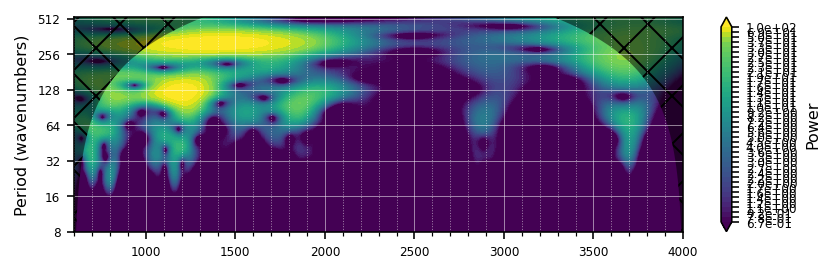

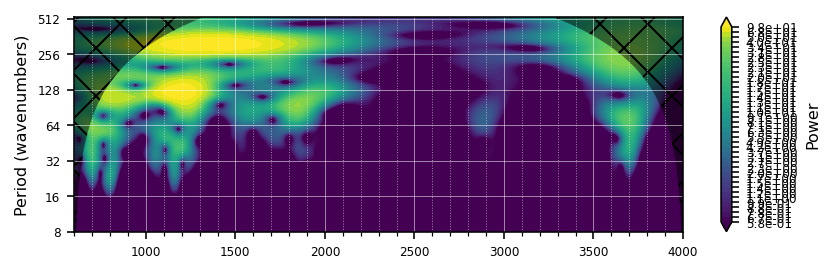

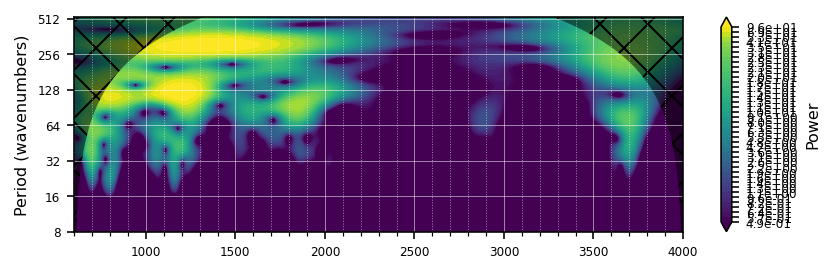

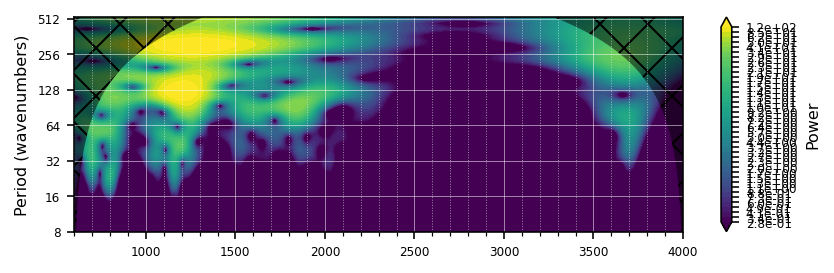

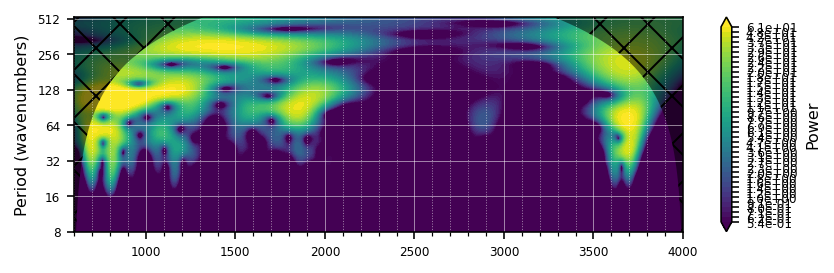

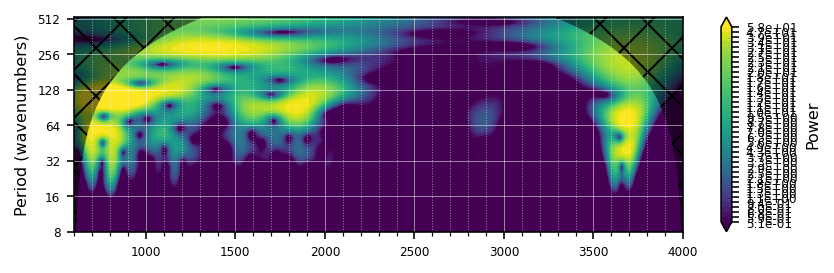

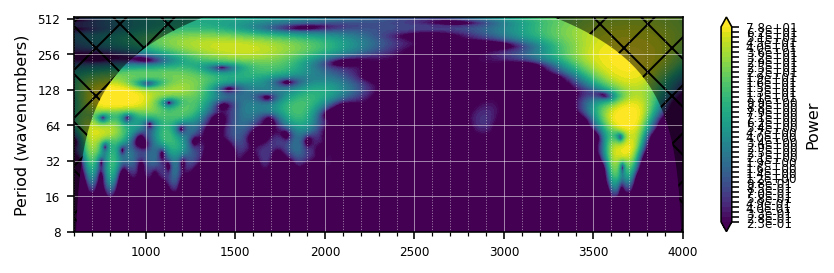

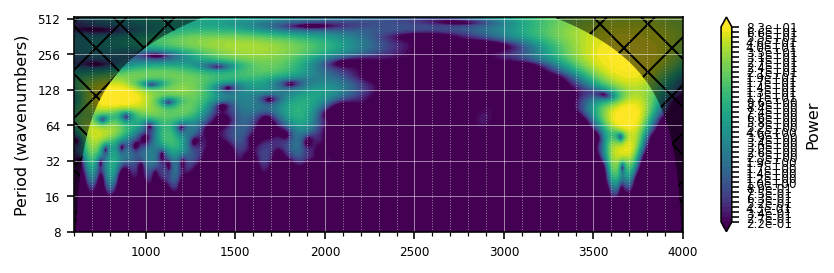

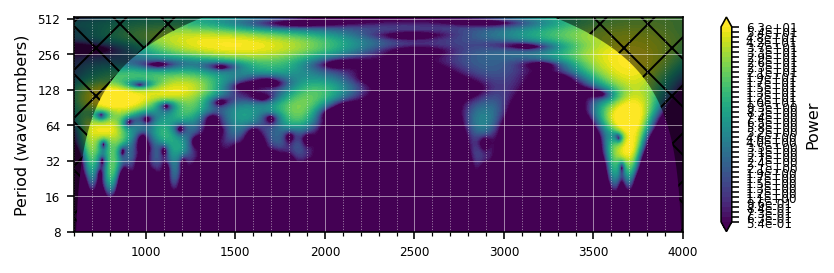

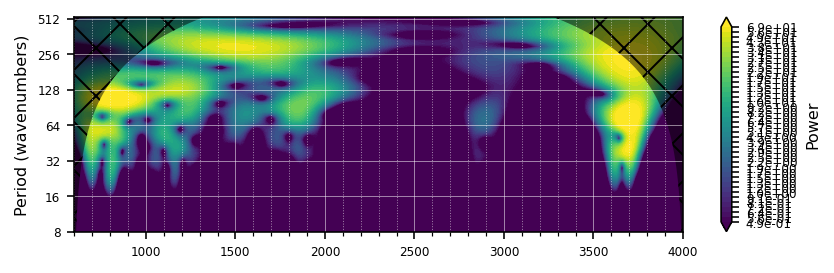

In [ ]:
#| eval: false
for i in range(0, 10):
    plot_cwt(CWT(X_trans[i, :])(), wavenumbers=wavenumbers)

In [ ]:
#| exports
def estimate_conversion_time(seconds=1000, samples=1000):
    "Estimate the time to convert all spectra to images."
    return seconds * (samples / 1000) / 60

In [ ]:
#| exports
def create_image_target_csv(smp_idx: np.ndarray, # sample indices     
                            y: np.ndarray, # target values
                            n_samples: int = None, # number of samples to process
                            output_dir: str = '../_data/ossl-tfm/', # path to save the CSV file
                            fname:str = 'ossl-tfm.csv'
                            ) -> None: 
    "Create a CSV file with the image names and the target values."
    n_samples = len(smp_idx) if n_samples is None else n_samples
    
    items = {
        'fname': [f'{id}.png' for id in smp_idx[:n_samples]],
        'kex': [np.log1p(y[i].item()) for i in range(n_samples)]
    }
    
    pd.DataFrame(items).to_csv(Path(output_dir) / fname, index=False)

In [ ]:
#| eval: false
create_image_target_csv(smp_idx, y, n_samples=10)  
pd.read_csv('../_data/ossl-tfm/ossl-tfm.csv').head()

,fname,kex
0,3998362dd2659e2252cd7f38b43c9b1f.png,0.182895
1,2bab4dbbac073b8648475ad50d40eb95.png,0.082741
2,29213d2193232be8867d85dec463ec00.png,0.089915
3,8b1ee9146c026faee20a40df86736864.png,0.135030
4,6e8e9d1105e7da7055555cb5d310df5f.png,0.270421


In [ ]:
#| exports
def create_output_directory(output_dir):
    "Create the output directory if it does not exist."
    os.makedirs(output_dir, exist_ok=True)

In [ ]:
#| exports
def process_single_sample(args):
    "Process a single sample and save the wavelet image to the output directory."
    i, id, X_trans_i, wavenumbers, output_dir, cwt_kwargs, plot_kwargs = args
    fname_img = f'{output_dir}/{id}.png'
    cwt_result = CWT(X_trans_i, **cwt_kwargs)()
    plot_cwt(cwt_result, wavenumbers=wavenumbers, 
             save_path=fname_img, show_plot=False, **plot_kwargs)

In [ ]:
#| exports
def batch_indices(n_samples: int, batch_size: int) -> range:
    "Generate batch indices for processing."
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        yield range(start, end)

In [ ]:
#| exports
def convert_to_wavelet_images(X_trans: np.ndarray,
                              smp_idx: np.ndarray,
                              wavenumbers: np.ndarray,
                              output_dir: str = '../_data/img',
                              cwt_kwargs: dict = None,
                              plot_kwargs: dict = None,
                              n_samples: int = None,
                              batch_size: int = 100,
                              n_workers: int = None) -> None:
    "Process samples in parallel batches and save wavelet images to output directory."
    create_output_directory(output_dir)
    
    cwt_kwargs = cwt_kwargs or {}
    plot_kwargs = plot_kwargs or {}

    n_samples = len(smp_idx) if n_samples is None else min(n_samples, len(smp_idx))
    n_workers = n_workers or max(1, cpu_count() - 1)  # Use all cores except one by default
    
    with tqdm(total=n_samples, desc="Processing samples") as pbar:
        for batch in batch_indices(n_samples, batch_size):
            args = [(i, smp_idx[i], X_trans[i, :], wavenumbers, output_dir, cwt_kwargs, plot_kwargs) for i in batch]
            with Pool(n_workers) as pool:
                pool.map(process_single_sample, args)
            
            pbar.update(len(batch))
    
    return None

In [ ]:
#| eval: false
convert_to_wavelet_images(X_trans, smp_idx, wavenumbers, 
                          output_dir='../_data/ossl-tfm/img', n_samples=200, batch_size=100)

Processing samples: 100%|██████████| 200/200 [00:19<00:00, 10.31it/s]

CPU times: user 25.9 ms, sys: 67.7 ms, total: 93.6 ms
Wall time: 19.4 s
